# LegacyHalos Sample Selection

The goal of this notebook is to select our parent sample of central galaxies with Legacy Survey photometry.

The input (row-matched) catalogs are:
* \$REDMAPPER_DIR/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog.fit
* \$REDMAPPER_DIR/v6.3.1/redmapper-v6.3.1-lgt5-sdssWISEphot-dr14.fits (generated by [redmapper-sdssWISEphot.ipynb](https://github.com/moustakas/legacyhalos/tree/master/doc/redmapper-sdssWISEphot.ipynb))
* $REDMAPPER_DIR/v6.3.1/legacysurvey-dr6-dr7-redmapper-v6.3.1.fits (generated by [match-legacysurvey-redmapper.slurm](https://github.com/moustakas/legacyhalos/tree/master/bin/match-legacysurvey-redmapper.slurm))

The output catalog is a single file:

* \$LEGACYHALOS_DIR/sample/legacyhalos-sample-dr6-dr7.fits

### Imports

In [27]:
import os, warnings
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import fitsio
from astropy.io import fits
from astropy.table import Table, Column, hstack, join
import astropy.units as u
from astropy.coordinates import SkyCoord

In [3]:
import legacyhalos.io

In [4]:
plt.style.use('seaborn-talk')
%matplotlib inline

### Specify the LegacyHalos path and output files names.

In [5]:
legacyhalos_dir = os.getenv('LEGACYHALOS_DIR')
if not os.path.exists(legacyhalos_dir):
    os.makedirs(legacyhalos_dir)

In [6]:
lsdr, sdssdr, rmversion = 'dr6-dr7', 'dr14', 'v6.3.1'

In [7]:
samplefile = os.path.join( legacyhalos.io.sample_dir(), 'legacyhalos-sample-{}.fits'.format(lsdr) )

### Read the matched Legacy Survey and redMaPPer catalogs.

In [8]:
def read_legacysurvey(lsdr='dr6-dr7', rmversion='v6.3.1'):
    """Read the matched Legacy Survey catalog.
    
    Note that non-matching entries are populated with zeros / False.
    
    """
    lsfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                           'legacysurvey-{}-redmapper-{}-lgt5.fits'.format(lsdr, rmversion) )
    ls = Table(fits.getdata(lsfile, ext=1, upper=True))
    print('Read {} objects from {}'.format(len(ls), lsfile))

    return ls

In [9]:
def read_redmapper(rmversion='v6.3.1', index=None):
    """Read the parent redMaPPer cluster catalog and updated photometry.
    
    """
    rmfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                          'dr8_run_redmapper_{}_lgt5_catalog.fit'.format(rmversion) )
    rmphotfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                          'redmapper-{}-lgt5-sdssWISEphot-{}.fits'.format(rmversion, sdssdr) )
    
    if index is not None:
        rm = Table(fits.getdata(rmfile, ext=1, upper=True, rows=index))
        rmphot = Table(fits.getdata(rmphotfile, ext=1, upper=True, rows=index))
    else:
        rm = Table(fits.getdata(rmfile, ext=1, upper=True))
        rmphot = Table(fits.getdata(rmphotfile, ext=1, upper=True))
    print('Read {} objects from {}'.format(len(rm), rmfile))
    print('Read {} objects from {}'.format(len(rmphot), rmphotfile))
    
    rm.rename_column('RA', 'RA_REDMAPPER')
    rm.rename_column('DEC', 'DEC_REDMAPPER')
    rmphot.rename_column('RA', 'RA_SDSS')
    rmphot.rename_column('DEC', 'DEC_SDSS')
    rmphot.rename_column('OBJID', 'SDSS_OBJID')
    
    rmout = join(rmphot, rm, join_type='left', keys='MEM_MATCH_ID')

    # Add a central_id column
    #rmout.rename_column('MEM_MATCH_ID', 'CENTRAL_ID')
    cid = ['{:07d}'.format(cid) for cid in rmout['MEM_MATCH_ID']]
    rmout.add_column(Column(name='CENTRAL_ID', data=cid, dtype='U7'), index=0)
    
    return rmout

#### Require a match with redMaPPer and non-zero depth in all three bands.

In [10]:
lsall = read_legacysurvey(lsdr=lsdr, rmversion=rmversion)

Read 396047 objects from /Users/ioannis/research/data/redmapper/v6.3.1/legacysurvey-dr6-dr7-redmapper-v6.3.1-lgt5.fits


In [11]:
lsmatched = np.where( 
    (lsall['GALDEPTH_G'] > 0) * 
    (lsall['GALDEPTH_R'] > 0) * 
    (lsall['GALDEPTH_Z'] > 0) )[0]
print('Identified {} objects with grz photometry and a match to redMaPPer.'.format(len(lsmatched)))
ls = lsall[lsmatched]
ls

Identified 348212 objects with grz photometry and a match to redMaPPer.


RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,SUBPRIORITY,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS
int32,int32,str8,int32,str4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,str1
7000,482593,2396p272,2072,COMP,239.583350672,27.2334129284,5.97494e+12,7.48661e+12,1.07691e+06 .. 4.0628e+06,527.948,1363.82,2712.59,2612.08,1618.9,480.162,53.0176,2.69719,0.520497,0.35353,0.374935,0.0882475,0.000488414,9.62792e-06,0.877436,0.915691,0.951928,0.992543,0.995414,0.99902,0.99963,2,2,3,0.0779235,0.0683742,0.0764346,0.0507539,0.503457,0.0505295,0,0,0,905.539,186.473,70.8491,577.299,115.22,41.0466,0.912681,2.83234e+07,20.0893,32927.9,-0.0226788,1.74364e+06,-0.258173,3.83612e+06,2.82061,40356.6,0.0168729,280245.0,0.262299,582352.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,
6000,572069,2500p467,1670,DEV,250.082578006,46.711462028,3.46199e+11,1.19133e+12,144369.0 .. 376229.0,147.41,527.733,1163.1,1197.5,859.096,-65.1644,-793.788,1.84763,0.765274,0.258071,0.509654,0.121789,0.000497963,9.66727e-06,0.931227,0.953137,0.97351,0.995929,0.997498,0.999466,0.999798,2,3,3,0.120053,0.113457,0.0970222,0.187235,0.187346,0.169269,0,0,0,430.382,219.317,121.218,288.548,141.423,60.3265,1.0,1.0,18.7865,1442.04,-0.159928,663003.0,-0.120635,522466.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0904766,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,N
7000,323959,1978m012,654,EXP,197.872890293,-1.34106615034,2.78922e+12,2.03446e+12,363246.0 .. 722708.0,50.8708,156.504,304.322,333.082,241.042,79.1791,73.512,72.5422,17.8823,4.71529,1.41497,0.292565,0.000632376,1.54046e-05,0.922853,0.947355,0.970202,0.995414,0.997181,0.999398,0.999773,3,2,3,0.287918,0.307967,0.278035,0.00432044,4.88644e-06,0.00181586,0,0,0,1469.35,351.399,99.5028,902.535,236.287,55.4695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.53264,166835.0,0.0983603,1.30075e+06,-0.0843288,1.09318e+06,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,
7000,485119,2306p277,2019,EXP,230.600056876,27.7145281741,3.73314e+12,3.36573e+12,170594.0 .. 17069.2,11.8119,27.3543,54.3975,36.617,37.4313,28.3552,226.439,229.182,71.1476,30.4245,5.10658,0.980251,0.00282423,5.85008e-05,0.888785,0.923653,0.956549,0.993273,0.995863,0.999116,0.999666,4,4,4,4.98863,4.44155,5.00402,2.36845e-08,0.0,2.46922e-10,0,0,0,2064.1,756.88,96.5911,1311.21,419.772,61.1043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354911,93796.3,0.425941,4094.1,-0.263689,4763.18,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,
7000,393942,1374p110,1817,EXP,137.300728888,10.9736375496,5.73465e+11,4.2355e+11,16313.1

In [12]:
rmall = read_redmapper(rmversion=rmversion)
assert(len(rmall) == len(lsall))

Read 396047 objects from /Users/ioannis/research/data/redmapper/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog.fit
Read 396047 objects from /Users/ioannis/research/data/redmapper/v6.3.1/redmapper-v6.3.1-lgt5-sdssWISEphot-dr14.fits


In [13]:
rm = rmall[lsmatched]
rm

CENTRAL_ID,MEM_MATCH_ID,SDSS_OBJID,RUN,RERUN,CAMCOL,FIELD,RA_SDSS,DEC_SDSS,PETROMAGGIES [5],PETROMAGGIES_IVAR [5],MODELMAGGIES [5],MODELMAGGIES_IVAR [5],CMODELMAGGIES [5],CMODELMAGGIES_IVAR [5],WISE_NANOMAGGIES [2],WISE_NANOMAGGIES_IVAR [2],EXTINCTION [5],PETROR50 [5],RA_REDMAPPER,DEC_REDMAPPER,MODEL_MAG [5],MODEL_MAGERR [5],IMAG,IMAG_ERR,ZRED,ZRED_E,ZRED_CHISQ,BCG_SPEC_Z,Z_SPEC_INIT,Z_INIT,Z,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_ZRED,LAMBDA_ZRED_E,R_LAMBDA,SCALEVAL,MASKFRAC,C_LAMBDA [4],C_LAMBDA_ERR [4],MAG_LAMBDA_ERR [5],CHISQ,Z_LAMBDA,Z_LAMBDA_E,Z_LAMBDA_NITER,EBV_MEAN,PHOTOID,LNLAMLIKE,LNBCGLIKE,LNLIKE,PZBINS [21],PZ [21],NCROSS,RMASK,RA_ORIG,DEC_ORIG,W,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,LAMBDA_CHISQ_C,LAMBDA_CHISQ_CE,NCENT,NCENT_GOOD,RA_CENT [5],DEC_CENT [5],ID_CENT [5],LAMBDA_CHISQ_CENT [5],ZLAMBDA_CENT [5],P_BCG [5],P_CEN [5],Q_CEN [5],P_FG [5],Q_MISS,P_SAT [5],P_C [5],BCG_ILUM,ILUM,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,LIM_EXPTIME,LIM_LIMMAG,LIM_LIMMAG_HARD
str7,int32,int64,int64,int64,int64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,int64,float32,float32,float32,float32,float32,int16,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0000001,1,1237662340012638224,3927,301,2,85,239.583335437,27.2334095464,95.8095 .. 4284.27,0.000654984 .. 1.62822e-06,62.9277 .. 3331.97,0.121141 .. 0.00400068,29.5241 .. 3215.09,0.532083 .. 0.00430256,39647.6 .. 42470.3,0.000414198 .. 4.17227e-05,0.187233 .. 0.0557857,101.315 .. 25.6271,239.583329069,27.2334129178,17.7673 .. 13.6197,0.0495718 .. 0.00515177,13.979,0.00269815,0.0976015,0.00598646,17.5295,0.0908067,0.0908067,0.0976015,0.0995999,169.838,4.18703,167.9,3.82714,1.11175,1.01137,0.012301,1.91101 .. 0.340558,0.00478467 .. 0.00015905,0.0047196 .. 0.0,17.1603,0.0948307,0.00458178,1,0.0156272,39270301200850016,417.533,3.98176,421.515,0.0689421 .. 0.120719,6.66542e-06 .. 8.29784e-06,1,1.66762,239.583329069,27.2334129178,1.09264,22.1429,-1019.21,431.903,85493.5,169.368,1.24138,5,2,239.583329069 .. 239.559634173,27.2334129178 .. 27.2721026726,25404293 .. 25404056,169.838 .. 165.795,0.0964975 .. 0.0,1.0 .. 1.0,0.874838 .. 5.36843e-07,0.752766 .. 4.61934e-07,0.000188751 .. 0.00250284,-4.7971,0.124973 .. 0.997497,0.843622 .. 3.31047e-06,7.45976,115.15,0.0964975,0.0015025,122.966,21.1772,21.2911
0000002,2,1237651715872325879,1453,301,5,57,250.082552977,46.7114748935,19.338 .. 200.168,0.0739838 .. 0.000865781,10.7362 .. 460.244,0.486459 .. 0.0149121,31.4261 .. 274.856,0.074432 .. 0.0401029,7234.43 .. 8665.86,0.00300798 .. 0.000288756,0.102034 .. 0.0304007,10.4942 .. 2.44081,250.082548387,46.7115313536,19.7931 .. 15.8147,0.144956 .. 0.0193181,16.2903,0.0075439,0.263556,0.00704976,16.1534,-1.0,-1.0,0.233135,0.233327,199.539,5.29983,173.621,5.04967,1.14817,0.995171,0.0,1.80072 .. 0.32185,0.116592 .. 0.00175495,0.115213 .. 0.0,22.2347,0.232764,0.00615558,1,0.0268378,14530301500570247,382.432,1.15807,383.59,0.196232 .. 0.269297,3.38395e-07 .. 5.93477e-06,1,1.72225,250.086476355,46.7122681373,1.25965,7.30459,-56.4033,228.875,22720.9,199.594,0.463512,5,2,250.082548387 .. 250.107576522,46.7115313536 .. 46.7094645939,3352952 .. 3352965,199.539 .. 210.08,0.231425 .. 0.0,1.0 .. 1.0,0.985673 .. 3.25354e-06,0.633526 .. 2.09117e-06,0.0115227 .. 0.129715,-2.05149,0.00280448 .. 0.870282,0.639414 .. 5.85322e-06,5.72643,132.716,0.231425,0.00207641,94.0304,21.0016,21.2911
0000003,3,1237655500272500810,2334,301,6,13,197.872956459,-1.3411176982,-19.8656 .. 108.208,0.00854354 .. 4.0306e-05,5.86714 .. 920.437,0.139 .. 0.00699053,1.85612 .. 464.897

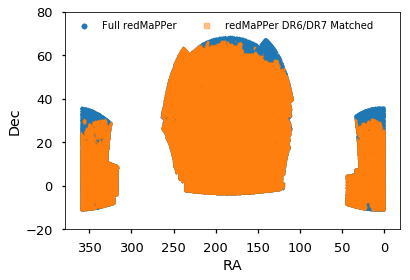

In [14]:
fig, ax = plt.subplots()
ax.scatter(rmall['RA_SDSS'], rmall['DEC_SDSS'], s=1, label='Full redMaPPer')
ax.scatter(rm['RA_SDSS'], rm['DEC_SDSS'], s=1, alpha=0.5, marker='s', label='redMaPPer DR6/DR7 Matched')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_ylim(-20, 80)
ax.invert_xaxis()
lgnd = ax.legend(loc='upper left', frameon=False, fontsize=10, ncol=2)
for ll in lgnd.legendHandles:
    ll._sizes = [30]

### Additional sample cuts

Require the DR6/DR7 *grz* photometry of each source to be deeper than the final (goal) survey depth.  In other words, exclude the sources with the shallowest *grz* photometry.

In [21]:
band = ['G', 'R', 'Z']
targdepth = [24.0, 23.4, 22.5] # target 5-sigma depth
meddepth, p10depth = np.zeros((3)), np.zeros((3))

g depth: P10: 24.003, median = 24.501, target = 24.000
r depth: P10: 23.511, median = 24.002, target = 23.400
z depth: P10: 22.799, median = 23.212, target = 22.500


(21, 26)

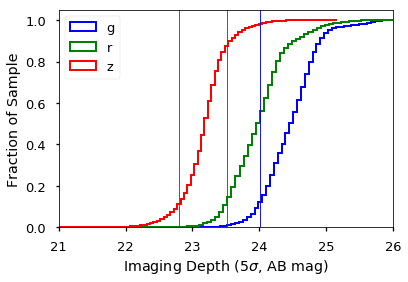

In [34]:
color = ('blue', 'green', 'red')
fig, ax = plt.subplots()
for ii, (tt, bb, col) in enumerate( zip( targdepth, band, color ) ):
    depth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(ls['PSFDEPTH_{}'.format(bb)]) )
    meddepth[ii] = np.percentile(depth, [50])
    p10depth[ii] = np.percentile(depth, [10])
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        nn, bins, patches = ax.hist(depth, bins=100, histtype='step', cumulative=True,
                                    label=bb.lower(), normed=True, color=col, lw=2)
    patches[0].set_xy(patches[0].get_xy()[:-1]) # delete the last point
    print('{} depth: P10: {:.3f}, median = {:.3f}, target = {:.3f}'.format(
        bb.lower(), p10depth[ii], meddepth[ii], tt))
    #ax.axvline(x=tt, ls='--', color=col, lw=2, alpha=1.0)
    #ax.axvline(x=meddepth[ii], ls='-', color=col, lw=1, alpha=0.9)
    ax.axvline(x=p10depth[ii], ls='-', color=col, lw=1, alpha=0.9)
ax.legend(loc='upper left')
ax.set_xlabel('Imaging Depth (5$\sigma$, AB mag)')
ax.set_ylabel('Fraction of Sample')
ax.set_xlim(21, 26)

In [38]:
depthcut = np.ones(len(ls)).astype(bool)
for ii, bb in enumerate(['G', 'R', 'Z']):
    depth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(ls['PSFDEPTH_{}'.format(bb)]) )
    #depthcut *= depth > meddepth[ii]
    depthcut *= depth > targdepth[ii]
print('{} / {} ({:.1f}%) objects pass the depth cuts in all three bands.'.format(
    np.sum(depthcut), len(ls), 100*np.sum(depthcut)/len(ls)))

296681 / 348212 (85.2%) objects pass the depth cuts in all three bands.


### Cut and join the redMaPPer and LS catalogs

In [39]:
rmdeep = rm[depthcut]
lsdeep = ls[depthcut]
sample = hstack( (rmdeep, lsdeep) )

In [40]:
def _normhist(xx, ax, label=None, alpha=1.0, lw=2, bins=100):
    _, _, _ = ax.hist(xx, weights=np.ones_like(xx) / float(len(xx)), 
                      bins=bins, histtype='step', label=label,
                      lw=lw, alpha=alpha)

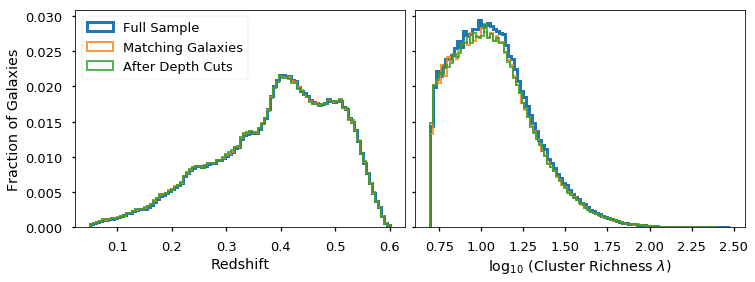

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

_normhist(rmall['Z'], ax1, label='Full Sample', lw=3)
_normhist(rm['Z'], ax1, label='Matching Galaxies', alpha=0.8)
_normhist(rmdeep['Z'], ax1, label='After Depth Cuts', alpha=0.8)
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Fraction of Galaxies')
ax1.legend(loc='upper left')

_normhist(np.log10(rmall['LAMBDA_CHISQ']), ax2, lw=3)
_normhist(np.log10(rm['LAMBDA_CHISQ']), ax2, alpha=0.8)
_normhist(np.log10(rmdeep['LAMBDA_CHISQ']), ax2, alpha=0.8)
ax2.set_xlabel('$\log_{10}$ (Cluster Richness $\lambda$)')
#ax2.set_ylabel('Fraction of Galaxies')
fig.subplots_adjust(wspace=0.03)

### Write out the final sample

In [21]:
print('Writing {}'.format(samplefile))
sample.write(samplefile, overwrite=True)

Writing /Users/ioannis/research/projects/legacyhalos/sample/legacyhalos-sample-dr6-dr7.fits
